In [1]:
import os, sys
from pathlib import Path
# sys.path.append(os.path.dirname(os.path.abspath('.')))
os.chdir('/home/kai/DigitalICU/EMBC2023')

import json
import glob
import pickle

import pandas as pd
from copy import deepcopy
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, auc
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In [2]:
eval_pred_cnn = pickle.load(open('models/eval_prediction_cnn.pkl', 'rb'))
eval_pred_xgb = pickle.load(open('models/eval_prediction_xgboost.pkl', 'rb'))
eval_pred = dict(eval_pred_cnn, **eval_pred_xgb)

del eval_pred_cnn
del eval_pred_xgb

In [3]:
def curve_scores(tn, fp, fn, tp):
    tpr = tp/(tp+fn)
    tnr = tn/(tn+fp)
    fpr = fp/(tn+fp)
    ppv = tp/(tp+fp)
    
    return tpr, tnr, fpr, ppv

def calc_curve(y_true, y_prob):
    curves = { 'tpr':[], 'tnr':[], 'fpr':[], 'ppv':[], 'thres':[]}
    for thres in tqdm(np.linspace(0, 1, 1001)):
        pred = [0 if y < thres else 1 for y in y_prob]
        tn, fp, fn, tp = confusion_matrix(y_true, pred).ravel()
        tpr, tnr, fpr, ppv = curve_scores(tn, fp, fn, tp)
        curves['tpr'].append(tpr)
        curves['tnr'].append(tnr)
        curves['fpr'].append(fpr)
        curves['ppv'].append(ppv)
        curves['thres'].append(thres)
    return curves

def plot_roc(ax, curves, label=None):
    ax.plot(curves['fpr'], curves['tpr'], label=label)
    ax.set_title('ROC Curve', fontsize=16)
    ax.set_xlabel('FPR', fontsize=13)
    ax.set_ylabel('TPR', fontsize=13)
    return ax

def plot_ssc(ax, curves, label=None):
    ax.plot(curves['tnr'], curves['tpr'], label=label)
    ax.set_title('Specificity-Recall Curve', fontsize=16)
    ax.set_xlabel('TNR', fontsize=13)
    ax.set_ylabel('TPR', fontsize=13)
    return ax

def plot_prc(ax, curves, label=None):
    ax.plot(curves['tpr'], curves['ppv'], label=label)
    ax.set_title('Recall-Precision Curve', fontsize=16)
    ax.set_xlabel('TPR', fontsize=13)
    ax.set_ylabel('PPV', fontsize=13)
    return ax

In [4]:
DATATYPE = {
    'CNN': ['raw', 'encoded'],
    'XGBoost': ['avg', 'max'],
}

model_curves = {}

for model_type in ['randomforest', 'XGBoost', 'CNN']:
    model_curves[model_type] = {}
    for split in ['subject']:
        model_curves[model_type][split] = {}
        if model_type == 'CNN':
            datatype_list = DATATYPE['CNN']
        else:
            datatype_list = DATATYPE['XGBoost']
        for datatype in datatype_list:
            model_curves[model_type][split][datatype] = {}
            for pred_task in ['mortality', 'los']:
                if pred_task == 'mortality':
                    y_true = eval_pred[model_type][split][datatype][pred_task]['y_true']
                    y_prob = eval_pred[model_type][split][datatype][pred_task]['y_prob']
                    y_pred = eval_pred[model_type][split][datatype][pred_task]['y_pred']
                    
                    curves = calc_curve(y_true, y_prob)
                    model_curves[model_type][split][datatype][pred_task] = curves

                else:
                    model_curves[model_type][split][datatype][pred_task] = {}
                    for los in [7, 14, 21]:
                        y_true = eval_pred[model_type][split][datatype][pred_task][los]['y_true']
                        y_prob = eval_pred[model_type][split][datatype][pred_task][los]['y_prob']
                        y_pred = eval_pred[model_type][split][datatype][pred_task][los]['y_pred']
                        
                        curves = calc_curve(y_true, y_prob)
                        model_curves[model_type][split][datatype][pred_task][los] = curves
pickle.dump(model_curves, open('models/model_curves.pkl', 'wb'))

# model_curves = pickle.load(open('models/model_curves.pkl', 'rb'))

100%|███████████████████████████████████████| 1001/1001 [00:34<00:00, 28.77it/s]


In [6]:
METRICS = {
    'auroc': None,
    'auprc': None,
    'accuracy': None,
    'recall': None,
    'precision': None,
    'specificity': None,
}


model_scores = {}

                    
for model_type in ['randomforest', 'XGBoost', 'CNN']:
    model_scores[model_type] = {}
    for split in ['subject']:
        model_scores[model_type][split] = {}
        if model_type == 'CNN':
            datatype_list = DATATYPE['CNN']
        else:
            datatype_list = DATATYPE['XGBoost']
        for datatype in datatype_list:
            model_scores[model_type][split][datatype] = {}
            for pred_task in ['mortality', 'los']:
                if pred_task == 'mortality':
                    y_true = eval_pred[model_type][split][datatype][pred_task]['y_true']
                    y_prob = eval_pred[model_type][split][datatype][pred_task]['y_prob']
                    y_pred = eval_pred[model_type][split][datatype][pred_task]['y_pred']

                    metrics = {}
                    curves = model_curves[model_type][split][datatype][pred_task]
                    metrics['auroc'] = roc_auc_score(y_true, y_prob)
                    presicion, recall, _ = precision_recall_curve(y_true, y_prob)
                    metrics['auprc'] = auc(recall, presicion)
                    metrics['accuracy'] = accuracy_score(y_true, y_pred)
                    metrics['recall'] = recall_score(y_true, y_pred, pos_label=1)
                    metrics['specificity'] = recall_score(y_true, y_pred, pos_label=0)
                    metrics['precision'] = precision_score(y_true, y_pred)
                    
                    model_scores[model_type][split][datatype][pred_task] = metrics


                else:
                    model_scores[model_type][split][datatype][pred_task] = {}
                    for los in [7, 14, 21]:
                        y_true = eval_pred[model_type][split][datatype][pred_task][los]['y_true']
                        y_prob = eval_pred[model_type][split][datatype][pred_task][los]['y_prob']
                        y_pred = eval_pred[model_type][split][datatype][pred_task][los]['y_pred']
                        
                        metrics = {}
                        curves = model_curves[model_type][split][datatype][pred_task][los]
                        metrics['auroc'] = roc_auc_score(y_true, y_prob)
                        presicion, recall, _ = precision_recall_curve(y_true, y_prob)
                        metrics['auprc'] = auc(recall, presicion)
                        metrics['accuracy'] = accuracy_score(y_true, y_pred)
                        metrics['recall'] = recall_score(y_true, y_pred, pos_label=1)
                        metrics['specificity'] = recall_score(y_true, y_pred, pos_label=0)
                        metrics['precision'] = precision_score(y_true, y_pred)
                        
                        model_scores[model_type][split][datatype][pred_task][los] = metrics

In [7]:
df_dict = {}
for model_type in model_scores.keys():
    df_dict[model_type] = {}
    for split in model_scores[model_type].keys():
        df_dict[model_type][split] = {}
        for datatype in model_scores[model_type][split].keys():
            df_dict[model_type][split][datatype] = {}
            for pred_task in model_scores[model_type][split][datatype].keys():
                df_dict[model_type][split][datatype][pred_task] = {}
                if pred_task == 'mortality':
                    df_dict[model_type][split][datatype][pred_task][0] = \
                        model_scores[model_type][split][datatype][pred_task]
                else:
                    for los in [7, 14, 21]:
                        df_dict[model_type][split][datatype][pred_task][los] = \
                            model_scores[model_type][split][datatype][pred_task][los]
                    
                    
df_dict_multiindex = {
    (model_type, split, datatype, pred_task, los): df_dict[model_type][split][datatype][pred_task][los]
    for model_type in df_dict.keys()
    for split in df_dict[model_type].keys()
    for datatype in df_dict[model_type][split].keys()
    for pred_task in df_dict[model_type][split][datatype].keys()
    for los in df_dict[model_type][split][datatype][pred_task].keys()
}

df_scores = pd.DataFrame.from_dict(
    df_dict_multiindex,
    orient='index'
)

In [8]:
df_scores

auroc     auprc  accuracy  \
randomforest subject avg     mortality 0   0.772952  0.420775  0.837370   
                             los       7   0.728819  0.803308  0.673822   
                                       14  0.708152  0.537956  0.706943   
                                       21  0.699781  0.354186  0.820318   
                     max     mortality 0   0.779552  0.437550  0.837528   
                             los       7   0.730905  0.802512  0.678981   
                                       14  0.711286  0.535618  0.706752   
                                       21  0.708266  0.358536  0.821146   
XGBoost      subject avg     mortality 0   0.800545  0.467186  0.838795   
                             los       7   0.759926  0.825754  0.704013   
                                       14  0.731590  0.571136  0.719682   
                                       21  0.717393  0.370281  0.818981   
                     max     mortality 0   0.797240  0.475055  0.841064   
                             los       7   0.746217  0.814570  0.690191   
                                       14  0.719980  0.555005  0.711783   
                                       21  0.703211  0.356730  0.816879   
CNN          subject raw     mortality 0   0.795009  0.464257  0.756847   
                             los       7   0.755030  0.814751  0.684140   
                                       14  0.733031  0.559830  0.682357   
                                       21  0.719750  0.361168  0.686497   
                     encoded mortality 0   0.828439  0.536263  0.757427   
                             los       7   0.773670  0.834579  0.698217   
                                       14  0.750914  0.585987  0.688917   
                                       21  0.747128  0.396345  0.687834   

                                             recall  specificity  precision  
randomforest subject avg     mortality 0   0.095970     0.990892   0.685714  
                             los       7   0.769247     0.527800   0.713699  
                                       14  0.316824     0.893988   0.588966  
                                       21  0.045661     0.993531   0.612150  
                     max     mortality 0   0.101815     0.989873   0.675510  
                             los       7   0.807056     0.482998   0.704903  
                                       14  0.280071     0.911327   0.602282  
                                       21  0.041826     0.995402   0.670391  
XGBoost      subject avg     mortality 0   0.277761     0.954968   0.560870  
                             los       7   0.776830     0.592587   0.744750  
                                       14  0.384631     0.880324   0.606446  
                                       21  0.149878     0.968592   0.516206  
                     max     mortality 0   0.293141     0.954522   0.571686  
                             los       7   0.756503     0.588719   0.737853  
                                       14  0.356329     0.882209   0.591903  
                                       21  0.126525     0.971242   0.495902  
CNN          subject raw     mortality 0   0.653645     0.778217   0.378991  
                             los       7   0.680147     0.690250   0.770644  
                                       14  0.593947     0.724746   0.508497  
                                       21  0.602649     0.705245   0.313736  
                     encoded mortality 0   0.726853     0.763758   0.389163  
                             los       7   0.680147     0.725866   0.791519  
                                       14  0.674528     0.695816   0.515315  
                                       21  0.655281     0.695113   0.324586

In [9]:
df_scores = df_scores.reindex(columns=df_scores.columns.to_list() + ['recall80', 'precision80', 'specificity80'])
for model_type in ['randomforest', 'XGBoost', 'CNN']:
    if model_type == 'CNN':
        datatype_list = ['raw', 'encoded']
    else:
        datatype_list = ['avg', 'max']
        
    for split in ['subject']:
        for datatype in datatype_list:
        
            for pred_task in ['mortality', 'los']:
                if pred_task == 'mortality':
                    recall_arr = np.array(model_curves[model_type][split][datatype][pred_task]['tpr'])
                    precision_arr = np.array(model_curves[model_type][split][datatype][pred_task]['ppv'])
                    specificity_arr = np.array(model_curves[model_type][split][datatype][pred_task]['tnr'])

                    idx_recall80 = np.argmin(np.abs(recall_arr-0.8))
                    recall80 = recall_arr[idx_recall80]
                    precision80 = precision_arr[idx_recall80]
                    specificity80 = specificity_arr[idx_recall80]
                    df_scores.loc[(model_type, split, datatype, pred_task, 0), 'recall80'] = recall80
                    df_scores.loc[(model_type, split, datatype, pred_task, 0), 'precision80'] = precision80
                    df_scores.loc[(model_type, split, datatype, pred_task, 0), 'specificity80'] = specificity80
#                     print(f'{model_type}-{pred_task}: {recall80}, {precision80}, {specificity80}')
                else:
                    for los in [7, 14, 21]:
                        recall_arr = np.array(model_curves[model_type][split][datatype][pred_task][los]['tpr'])
                        precision_arr = np.array(model_curves[model_type][split][datatype][pred_task][los]['ppv'])
                        specificity_arr = np.array(model_curves[model_type][split][datatype][pred_task][los]['tnr'])

                        idx_recall80 = np.argmin(np.abs(recall_arr-0.8))
                        recall80 = recall_arr[idx_recall80]
                        precision80 = precision_arr[idx_recall80]
                        specificity80 = specificity_arr[idx_recall80]
                        df_scores.loc[(model_type, split, datatype, pred_task, los), 'recall80'] = recall80
                        df_scores.loc[(model_type, split, datatype, pred_task, los), 'precision80'] = precision80
                        df_scores.loc[(model_type, split, datatype, pred_task, los), 'specificity80'] = specificity80
#                         print(f'{model_type}-{pred_task}-{los}: {recall80}, {precision80}, {specificity80}')   
df_scores

auroc     auprc  accuracy  \
randomforest subject avg     mortality 0   0.772952  0.420775  0.837370   
                             los       7   0.728819  0.803308  0.673822   
                                       14  0.708152  0.537956  0.706943   
                                       21  0.699781  0.354186  0.820318   
                     max     mortality 0   0.779552  0.437550  0.837528   
                             los       7   0.730905  0.802512  0.678981   
                                       14  0.711286  0.535618  0.706752   
                                       21  0.708266  0.358536  0.821146   
XGBoost      subject avg     mortality 0   0.800545  0.467186  0.838795   
                             los       7   0.759926  0.825754  0.704013   
                                       14  0.731590  0.571136  0.719682   
                                       21  0.717393  0.370281  0.818981   
                     max     mortality 0   0.797240  0.475055  0.841064   
                             los       7   0.746217  0.814570  0.690191   
                                       14  0.719980  0.555005  0.711783   
                                       21  0.703211  0.356730  0.816879   
CNN          subject raw     mortality 0   0.795009  0.464257  0.756847   
                             los       7   0.755030  0.814751  0.684140   
                                       14  0.733031  0.559830  0.682357   
                                       21  0.719750  0.361168  0.686497   
                     encoded mortality 0   0.828439  0.536263  0.757427   
                             los       7   0.773670  0.834579  0.698217   
                                       14  0.750914  0.585987  0.688917   
                                       21  0.747128  0.396345  0.687834   

                                             recall  specificity  precision  \
randomforest subject avg     mortality 0   0.095970     0.990892   0.685714   
                             los       7   0.769247     0.527800   0.713699   
                                       14  0.316824     0.893988   0.588966   
                                       21  0.045661     0.993531   0.612150   
                     max     mortality 0   0.101815     0.989873   0.675510   
                             los       7   0.807056     0.482998   0.704903   
                                       14  0.280071     0.911327   0.602282   
                                       21  0.041826     0.995402   0.670391   
XGBoost      subject avg     mortality 0   0.277761     0.954968   0.560870   
                             los       7   0.776830     0.592587   0.744750   
                                       14  0.384631     0.880324   0.606446   
                                       21  0.149878     0.968592   0.516206   
                     max     mortality 0   0.293141     0.954522   0.571686   
                             los       7   0.756503     0.588719   0.737853   
                                       14  0.356329     0.882209   0.591903   
                                       21  0.126525     0.971242   0.495902   
CNN          subject raw     mortality 0   0.653645     0.778217   0.378991   
                             los       7   0.680147     0.690250   0.770644   
                                       14  0.593947     0.724746   0.508497   
                                       21  0.602649     0.705245   0.313736   
                     encoded mortality 0   0.726853     0.763758   0.389163   
                             los       7   0.680147     0.725866   0.791519   
                                       14  0.674528     0.695816   0.515315   
                                       21  0.655281     0.695113   0.324586   

                                           recall80  precision80  \
randomforest subject avg     mortality 0   0.801292     0.290834   
                             los       7   0.800632     0.

In [10]:
df_scores_ = df_scores.xs('subject', level=1)[['auroc', 'auprc', 'accuracy', 'precision80', 'specificity80']]
df_scores_

auroc     auprc  accuracy  precision80  \
randomforest avg     mortality 0   0.772952  0.420775  0.837370     0.290834   
                     los       7   0.728819  0.803308  0.673822     0.700710   
                               14  0.708152  0.537956  0.706943     0.420211   
                               21  0.699781  0.354186  0.820318     0.252975   
             max     mortality 0   0.779552  0.437550  0.837528     0.299043   
                     los       7   0.730905  0.802512  0.678981     0.707626   
                               14  0.711286  0.535618  0.706752     0.423757   
                               21  0.708266  0.358536  0.821146     0.260232   
XGBoost      avg     mortality 0   0.800545  0.467186  0.838795     0.320415   
                     los       7   0.759926  0.825754  0.704013     0.733887   
                               14  0.731590  0.571136  0.719682     0.437031   
                               21  0.717393  0.370281  0.818981     0.254067   
             max     mortality 0   0.797240  0.475055  0.841064     0.311169   
                     los       7   0.746217  0.814570  0.690191     0.717891   
                               14  0.719980  0.555005  0.711783     0.428286   
                               21  0.703211  0.356730  0.816879     0.253498   
CNN          raw     mortality 0   0.795009  0.464257  0.756847     0.312425   
                     los       7   0.755030  0.814751  0.684140     0.729107   
                               14  0.733031  0.559830  0.682357     0.447980   
                               21  0.719750  0.361168  0.686497     0.270615   
             encoded mortality 0   0.828439  0.536263  0.757427     0.347966   
                     los       7   0.773670  0.834579  0.698217     0.741800   
                               14  0.750914  0.585987  0.688917     0.465515   
                               21  0.747128  0.396345  0.687834     0.284580   

                                   specificity80  
randomforest avg     mortality 0        0.595414  
                     los       7        0.476712  
                               14       0.470694  
                               21       0.471592  
             max     mortality 0        0.612866  
                     los       7        0.494601  
                               14       0.477949  
                               21       0.492869  
XGBoost      avg     mortality 0        0.649299  
                     los       7        0.556164  
                               14       0.505466  
                               21       0.456784  
             max     mortality 0        0.631146  
                     los       7        0.518936  
                               14       0.487279  
                               21       0.476035  
CNN          raw     mortality 0        0.635541  
                     los       7        0.545528  
                               14       0.527516  
                               21       0.518120  
             encoded mortality 0        0.689682  
                     los       7        0.573731  
                               14       0.559649  
                               21       0.550542

In [17]:
df_scores_.to_csv('models/model_scores.csv', float_format='%.3f')


In [23]:
df_scores_.iloc[
    (df_scores_.index.get_level_values(0)=='randomforest') &
    (df_scores_.index.get_level_values(1)=='max')
]

auroc     auprc  accuracy  precision80  \
randomforest max mortality 0   0.779552  0.437550  0.837528     0.299043   
                 los       7   0.730905  0.802512  0.678981     0.707626   
                           14  0.711286  0.535618  0.706752     0.423757   
                           21  0.708266  0.358536  0.821146     0.260232   

                               specificity80  
randomforest max mortality 0        0.612866  
                 los       7        0.494601  
                           14       0.477949  
                           21       0.492869

In [24]:
df_plot = pd.concat((
    df_scores_.iloc[
        (df_scores_.index.get_level_values(0)=='randomforest') &
        (df_scores_.index.get_level_values(1)=='max')
    ],
    df_scores_.iloc[
        (df_scores_.index.get_level_values(0)=='XGBoost') &
        (df_scores_.index.get_level_values(1)=='avg')
    ],
    df_scores_.iloc[
        (df_scores_.index.get_level_values(0)=='CNN') &
        (df_scores_.index.get_level_values(1)=='encoded')
    ],
))
df_plot

auroc     auprc  accuracy  precision80  \
randomforest max     mortality 0   0.779552  0.437550  0.837528     0.299043   
                     los       7   0.730905  0.802512  0.678981     0.707626   
                               14  0.711286  0.535618  0.706752     0.423757   
                               21  0.708266  0.358536  0.821146     0.260232   
XGBoost      avg     mortality 0   0.800545  0.467186  0.838795     0.320415   
                     los       7   0.759926  0.825754  0.704013     0.733887   
                               14  0.731590  0.571136  0.719682     0.437031   
                               21  0.717393  0.370281  0.818981     0.254067   
CNN          encoded mortality 0   0.828439  0.536263  0.757427     0.347966   
                     los       7   0.773670  0.834579  0.698217     0.741800   
                               14  0.750914  0.585987  0.688917     0.465515   
                               21  0.747128  0.396345  0.687834     0.284580   

                                   specificity80  
randomforest max     mortality 0        0.612866  
                     los       7        0.494601  
                               14       0.477949  
                               21       0.492869  
XGBoost      avg     mortality 0        0.649299  
                     los       7        0.556164  
                               14       0.505466  
                               21       0.456784  
CNN          encoded mortality 0        0.689682  
                     los       7        0.573731  
                               14       0.559649  
                               21       0.550542

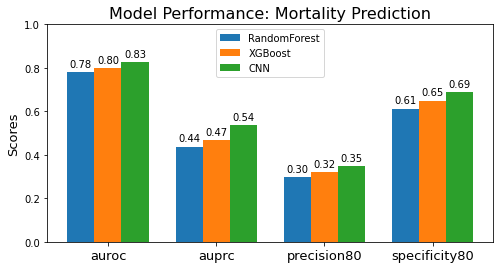

In [31]:
df_plot_mortality = df_plot.xs(('mortality', 0), level=(2, 3))
df_plot_mortality = df_plot_mortality[['auroc', 'auprc', 'precision80', 'specificity80']].transpose()
df_plot_mortality 

index = ['auroc', 'auprc', 'precision80', 'specificity80']
x = np.arange(len(index))  # the label locations
width = 0.25  # the width of the bars


fig, ax = plt.subplots(figsize=(8,4))
s1 = ax.bar(x - width, df_plot_mortality[('randomforest', 'max')], width, label='RandomForest')
s2 = ax.bar(x, df_plot_mortality[('XGBoost', 'avg')], width, label='XGBoost')
s3 = ax.bar(x + width, df_plot_mortality[('CNN', 'encoded')], width, label='CNN')

ax.bar_label(s1, padding=3, fmt='%.2f')
ax.bar_label(s2, padding=3, fmt='%.2f')
ax.bar_label(s3, padding=3, fmt='%.2f')

ax.set_ylabel('Scores', fontsize=13)
ax.set_title('Model Performance: Mortality Prediction', fontsize=16)
ax.set_xticks(x, index, fontsize=13)
ax.legend(loc='upper center')
ax.set_ylim(0,1)

fig.savefig('plots/model_performance_mortality.png', dpi=fig.dpi)

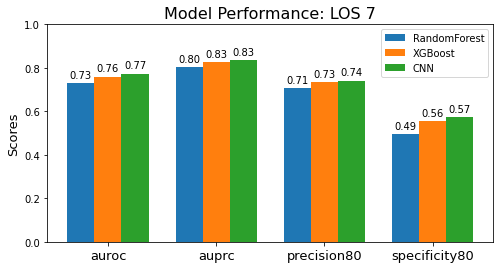

In [32]:
df_plot_los= df_plot.xs(('los', 7), level=(2, 3))
df_plot_los = df_plot_los[['auroc', 'auprc', 'precision80', 'specificity80']].transpose()

index = ['auroc', 'auprc', 'precision80', 'specificity80']
x = np.arange(len(index))  # the label locations
width = 0.25  # the width of the bars


fig, ax = plt.subplots(figsize=(8,4))
s1 = ax.bar(x - width, df_plot_los[('randomforest', 'max')], width, label='RandomForest')
s2 = ax.bar(x, df_plot_los[('XGBoost', 'avg')], width, label='XGBoost')
s3 = ax.bar(x + width, df_plot_los[('CNN', 'encoded')], width, label='CNN')

ax.bar_label(s1, padding=3, fmt='%.2f')
ax.bar_label(s2, padding=3, fmt='%.2f')
ax.bar_label(s3, padding=3, fmt='%.2f')

ax.set_ylabel('Scores', fontsize=13)
ax.set_title('Model Performance: LOS 7', fontsize=16)
ax.set_xticks(x, index, fontsize=13)
ax.legend(loc='upper right')
ax.set_ylim(0,1)


fig.savefig('plots/model_performance_los7.png', dpi=fig.dpi)

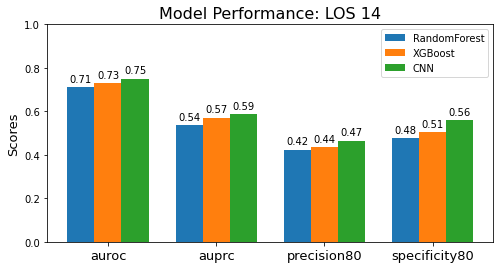

In [33]:
df_plot_los= df_plot.xs(('los', 14), level=(2, 3))
df_plot_los = df_plot_los[['auroc', 'auprc', 'precision80', 'specificity80']].transpose()

index = ['auroc', 'auprc', 'precision80', 'specificity80']
x = np.arange(len(index))  # the label locations
width = 0.25  # the width of the bars


fig, ax = plt.subplots(figsize=(8,4))
s1 = ax.bar(x - width, df_plot_los[('randomforest', 'max')], width, label='RandomForest')
s2 = ax.bar(x, df_plot_los[('XGBoost', 'avg')], width, label='XGBoost')
s3 = ax.bar(x + width, df_plot_los[('CNN', 'encoded')], width, label='CNN')

ax.bar_label(s1, padding=3, fmt='%.2f')
ax.bar_label(s2, padding=3, fmt='%.2f')
ax.bar_label(s3, padding=3, fmt='%.2f')

ax.set_ylabel('Scores', fontsize=13)
ax.set_title('Model Performance: LOS 14', fontsize=16)
ax.set_xticks(x, index, fontsize=13)
ax.legend()
ax.set_ylim(0,1)

fig.savefig('plots/model_performance_los14.png', dpi=fig.dpi)

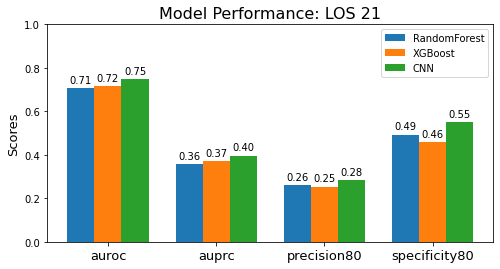

In [34]:
df_plot_los= df_plot.xs(('los', 21), level=(2, 3))
df_plot_los = df_plot_los[['auroc', 'auprc', 'precision80', 'specificity80']].transpose()

index = ['auroc', 'auprc', 'precision80', 'specificity80']
x = np.arange(len(index))  # the label locations
width = 0.25  # the width of the bars


fig, ax = plt.subplots(figsize=(8,4))
s1 = ax.bar(x - width, df_plot_los[('randomforest', 'max')], width, label='RandomForest')
s2 = ax.bar(x, df_plot_los[('XGBoost', 'avg')], width, label='XGBoost')
s3 = ax.bar(x + width, df_plot_los[('CNN', 'encoded')], width, label='CNN')

ax.bar_label(s1, padding=3, fmt='%.2f')
ax.bar_label(s2, padding=3, fmt='%.2f')
ax.bar_label(s3, padding=3, fmt='%.2f')

ax.set_ylabel('Scores', fontsize=13)
ax.set_title('Model Performance: LOS 21', fontsize=16)
ax.set_xticks(x, index, fontsize=13)
ax.legend()
ax.set_ylim(0,1)

fig.savefig('plots/model_performance_los21.png', dpi=fig.dpi)

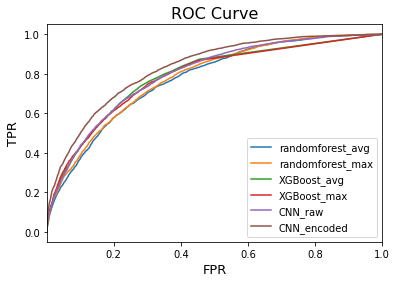

In [35]:
fig, ax = plt.subplots(figsize=(6,4))

for model_type in ['randomforest', 'XGBoost', 'CNN']:
    for split in ['subject']:
        if model_type == 'CNN':
            datatype_list = ['raw', 'encoded']
        else:
            datatype_list = ['avg', 'max']
            
        for datatype in datatype_list:
            pred_task = 'mortality'

            curves = model_curves[model_type][split][datatype][pred_task]

            plot_roc(ax, curves, label=f'{model_type}_{datatype}');
#             plot_prc(ax, curves, label=f'{model_type}_{datatype}');
#             plot_ssc(ax[1], curves, label=f'{model_type}_{datatype}');


ax.legend(loc='lower right')
ax.set_xlim(0.001, 1) 
    
fig.savefig('plots/curve_mordality_roc.png', dpi=fig.dpi)

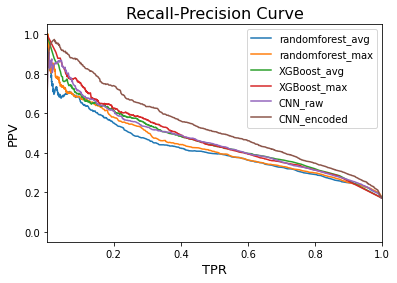

In [36]:
fig, ax = plt.subplots(figsize=(6,4))

for model_type in ['randomforest', 'XGBoost', 'CNN']:
    for split in ['subject']:
        if model_type == 'CNN':
            datatype_list = ['raw', 'encoded']
        else:
            datatype_list = ['avg', 'max']
            
        for datatype in datatype_list:
            pred_task = 'mortality'

            curves = model_curves[model_type][split][datatype][pred_task]

#             plot_roc(ax[0], curves, label=f'{model_type}_{datatype}');
            plot_prc(ax, curves, label=f'{model_type}_{datatype}');
#             plot_ssc(ax, curves, label=f'{model_type}_{datatype}');


ax.legend(loc='upper right')
ax.set_xlim(0.001, 1) 
    
fig.savefig('plots/curve_mordality_prc.png', dpi=fig.dpi)

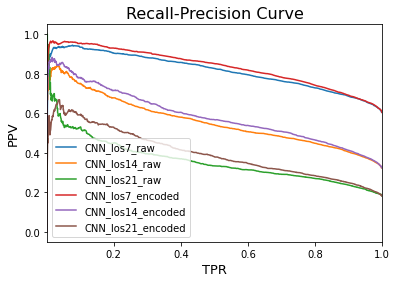

In [37]:
fig, ax = plt.subplots(figsize=(6,4))

for model_type in ['CNN']:
    for split in ['subject']:
        for datatype in ['raw', 'encoded']:
            for pred_task in ['los']:
                if pred_task == 'mortality':
                    curves = model_curves[model_type][split][datatype][pred_task]
                    plot_roc(ax[0], curves, label=f'{model_type}_{pred_task}');
                    plot_prc(ax[1], curves, label=f'{model_type}_{pred_task}');
                    plot_ssc(ax[2], curves, label=f'{model_type}_{pred_task}');
                else:
                    for los in [7, 14, 21]:
                        curves = model_curves[model_type][split][datatype][pred_task][los]
#                         plot_roc(ax[0], curves, label=f'{model_type}_{pred_task}{los}_{datatype}');
                        plot_prc(ax, curves, label=f'{model_type}_{pred_task}{los}_{datatype}');
#                         plot_ssc(ax, curves, label=f'{model_type}_{pred_task}{los}_{datatype}');

ax.set_xlim(0.001, 1) 
ax.legend(loc='lower left')

fig.savefig('plots/curve_los_prc.png', dpi=fig.dpi)

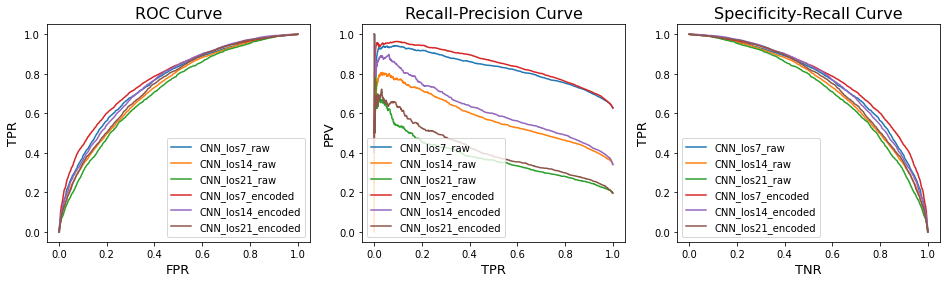

In [90]:
fig, ax = plt.subplots(1, 3, figsize=(16,4))

for model_type in ['CNN']:
    for split in ['subject']:
        for datatype in ['raw', 'encoded']:
            for pred_task in ['los']:
                if pred_task == 'mortality':
                    curves = model_curves[model_type][split][datatype][pred_task]
                    plot_roc(ax[0], curves, label=f'{model_type}_{pred_task}');
                    plot_prc(ax[1], curves, label=f'{model_type}_{pred_task}');
                    plot_ssc(ax[2], curves, label=f'{model_type}_{pred_task}');
                else:
                    for los in [7, 14, 21]:
                        curves = model_curves[model_type][split][datatype][pred_task][los]
                        plot_roc(ax[0], curves, label=f'{model_type}_{pred_task}{los}_{datatype}');
                        plot_prc(ax[1], curves, label=f'{model_type}_{pred_task}{los}_{datatype}');
                        plot_ssc(ax[2], curves, label=f'{model_type}_{pred_task}{los}_{datatype}');

for i in range(3):
    ax[i].legend()

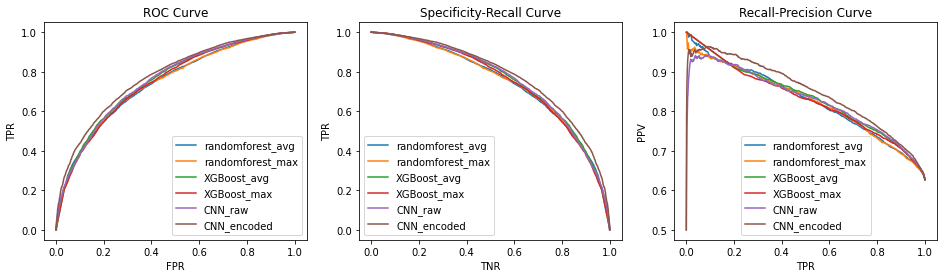

In [34]:
fig, ax = plt.subplots(1, 3, figsize=(16,4))

for model_type in ['randomforest', 'XGBoost', 'CNN']:
    for split in ['subject']:
        if model_type == 'CNN':
            datatype_list = ['raw', 'encoded']
        else:
            datatype_list = ['avg', 'max']
            
        for datatype in datatype_list:
            pred_task = 'los'

            curves = model_curves[model_type][split][datatype][pred_task][7]

            plot_roc(ax[0], curves, label=f'{model_type}_{datatype}');
            plot_prc(ax[1], curves, label=f'{model_type}_{datatype}');
            plot_ssc(ax[2], curves, label=f'{model_type}_{datatype}');

for i in range(3):
    ax[i].legend()

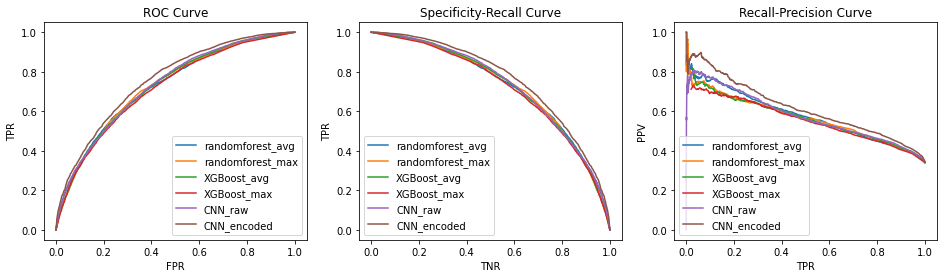

In [35]:
fig, ax = plt.subplots(1, 3, figsize=(16,4))

for model_type in ['randomforest', 'XGBoost', 'CNN']:
    for split in ['subject']:
        if model_type == 'CNN':
            datatype_list = ['raw', 'encoded']
        else:
            datatype_list = ['avg', 'max']
            
        for datatype in datatype_list:
            pred_task = 'los'

            curves = model_curves[model_type][split][datatype][pred_task][14]

            plot_roc(ax[0], curves, label=f'{model_type}_{datatype}');
            plot_prc(ax[1], curves, label=f'{model_type}_{datatype}');
            plot_ssc(ax[2], curves, label=f'{model_type}_{datatype}');

for i in range(3):
    ax[i].legend()

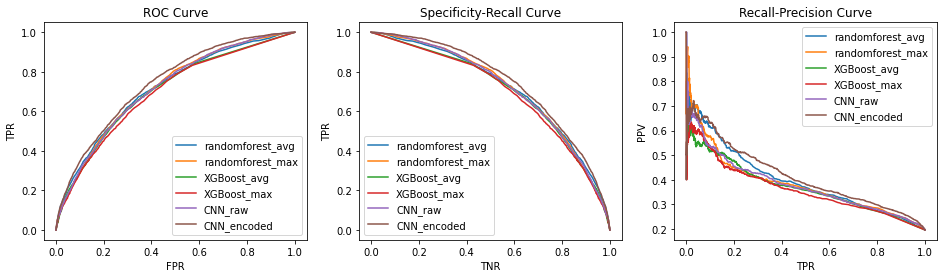

In [36]:
fig, ax = plt.subplots(1, 3, figsize=(16,4))

for model_type in ['randomforest', 'XGBoost', 'CNN']:
    for split in ['subject']:
        if model_type == 'CNN':
            datatype_list = ['raw', 'encoded']
        else:
            datatype_list = ['avg', 'max']
            
        for datatype in datatype_list:
            pred_task = 'los'

            curves = model_curves[model_type][split][datatype][pred_task][21]

            plot_roc(ax[0], curves, label=f'{model_type}_{datatype}');
            plot_prc(ax[1], curves, label=f'{model_type}_{datatype}');
            plot_ssc(ax[2], curves, label=f'{model_type}_{datatype}');

for i in range(3):
    ax[i].legend()